# Linear Frequency-Dependent PTO 

In [1]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_freqdep_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

### WEC

In [2]:
## WEC object
# mesh
wb = wot.geom.WaveBot() 
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE, rho=1025.0).
INF

### PTO(s)

In [3]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0 
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        -1/(1j*wec.omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape) 
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# create PTOs
pto_ps = wot.pto.PseudoSpectralLinearPTO(nfreq, kinematics, pto_impedance)
pto_pi = wot.pto.PILinearPTO(nfreq, kinematics, pto_impedance)
pto_p = wot.pto.PLinearPTO(nfreq, kinematics, pto_impedance)

### Thévenin Equivalent System & Natural Frequency

In [4]:
Z_11 = pto_impedance[0, 0, :]
Z_12 = pto_impedance[0, 1, :]
Z_21 = pto_impedance[1, 0, :]
Z_22 = pto_impedance[1, 1, :]

idof = 0
Z_i = wec.hydro.Zi[:, idof, idof]
Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Z_i)

ind = np.argmin(np.abs(Z_th.values), axis=0)
natfreq = wec.freq[ind]

natfreq, 1/natfreq


(0.05, 20.0)

Text(0, 0.5, 'Z_th')

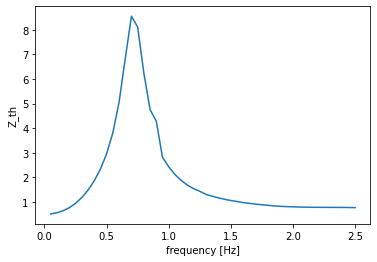

In [5]:
plt.figure()

plt.plot(wec.freq, np.abs(Z_th.values))
plt.xlabel("frequency [Hz]")
plt.ylabel("Z_th")

### Waves

In [6]:
# waves
wfreq = natfreq
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

### Solve

In [7]:
pto = pto_p

# add PTO force to WEC
wec.f_add = pto.force_on_wec

# objective function
obj_fun = pto.electric_average_power
nstate_opt = pto.nstate

# solve
scale_x_wec = 1.0
scale_x_opt = 0.0001
scale_obj = 1.0

options = {'maxiter': 100, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)


INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.21e+04, 8.48e+05, 3.30e+30]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.66e-03, 8.42e-01, 1.16e+03]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.70e-04, 8.41e-01, 8.99e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.70e-04, 8.41e-01, 8.98e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.70e-04, 8.41e-01, 8.98e-01]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8983310206549916
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 5


### CC (Electrical) Solution

In [8]:
Fe = wec_fdom['excitation_force'][1:, idof]

V_th = Z_21 / (Z_11 - Z_i) * Fe

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)

### Compare Results to CC

Text(0, 0.5, 'electrical power [W]')

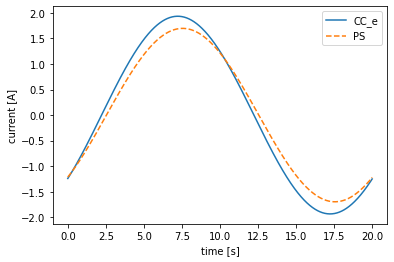

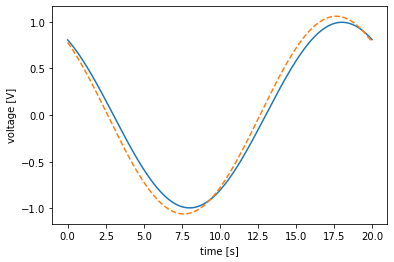

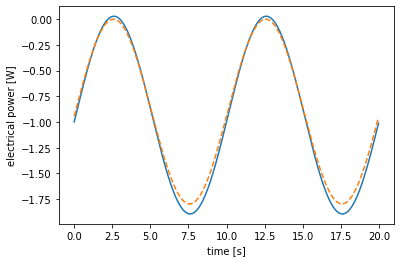

In [9]:
nsubsteps = 10
t = wec.make_time_vec(nsubsteps)

# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')